In [2]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

In [3]:
house = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/AI4Environment/solar_home_system_data_log-master/data/House_2_January_TimeSeries.csv')
house2 = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/AI4Environment/solar_home_system_data_log-master/data/House_3_January_TimeSeries.csv')
house3 = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/AI4Environment/solar_home_system_data_log-master/data/House_4_January_TimeSeries.csv')

house2.head(5)



,Time,#0: CH0 [Â°C],#1: CH1 [V],#2: CH2 [Digit],#3: CH3 [V],#4: CH4 [Digit],PV Current,Battery Current
0,6/23/15 12:28,30.40,18.37,32777,12.89,32779,-0.114042,-0.09240
1,6/23/15 12:29,30.42,18.95,32776,12.88,32779,-0.095035,-0.09240
2,6/23/15 12:30,30.43,18.79,32774,12.88,32777,-0.057021,-0.05544
3,6/23/15 12:31,30.43,13.30,32760,12.80,32750,0.209077,0.44352
4,6/23/15 12:32,30.42,13.23,32766,12.75,32745,0.095035,0.53592


In [4]:

columns = ['Time', 'Temperature', 'PV_V', 'Digit', 'Battery_V', 'Digit2', 'PV_Current', 'Battery_Current']
house.columns = columns
house2.columns = columns
house3.columns = columns

In [5]:
# Convert to time values 
house['Time'] = pd.to_datetime(house['Time'])
house_time = house.set_index(house['Time'])
house_time.drop('Time', inplace=True, axis=1)

house2['Time'] = pd.to_datetime(house2['Time'])
house2_time = house2.set_index(house2['Time'])
house2_time.drop('Time', inplace=True, axis=1)

house3['Time'] = pd.to_datetime(house3['Time'])
house3_time = house3.set_index(house3['Time'])
house3_time.drop('Time', inplace=True, axis=1)

In [6]:

#Values of slope and zero are based on experimental data calibrating
#digital readings of current to current values in Amps

# calibration slope for 3 amps
slope_channel_2 = [ -0.0190226, -0.0181098, -0.018034, -0.0184049, 0.0185455]
slope_channel_4 = [ 0.017730, -0.01779, -0.01845, -0.018519, 0.018765]

zero_channel_2 = [32766, 32786, 32776, 32771, 32774]
zero_channel_4 = [32775, 32785, 32777, 32771, 32775]

house_number = 2

#pv.current_adj = (pv.current-zero.channel_2(house_number))*slope.channel_2(house_number);
#battery.current_adj = (battery.current-zero.channel_4(house_number))*slope.channel_4(house_number);

house['PV_Current_Adj'] = (house['PV_Current'] - zero_channel_2[house_number])*slope_channel_2[house_number]
house['Battery_Current_Adj'] = (house['Battery_Current'] - zero_channel_4[house_number])*slope_channel_4[house_number]

# Set negative PV current values to 0 

house['PV_Current_Adj'] = np.where(house['PV_Current_Adj'] < 0, 0, house['PV_Current_Adj'])

In [7]:
# Calculate load values 

house['PV_Power'] = house['PV_V'] * house['PV_Current']
house['Battery_Power'] = house['Battery_V'] * house['Battery_Current']
house['Load'] = house['PV_Power'] + house['Battery_Power']

# Set negative load values to 0 
house['Load_Corrected'] = np.where(house['Load'] < 0, 0, house['Load'])

# Calculate load values 

house2['PV_Power'] = house2['PV_V'] * house2['PV_Current']
house2['Battery_Power'] = house2['Battery_V'] * house2['Battery_Current']
house2['Load'] = house2['PV_Power'] + house2['Battery_Power']

# Set negative load values to 0 
house2['Load_Corrected'] = np.where(house2['Load'] < 0, 0, house2['Load'])

# Calculate load values 

house3['PV_Power'] = house3['PV_V'] * house3['PV_Current']
house3['Battery_Power'] = house3['Battery_V'] * house3['Battery_Current']
house3['Load'] = house3['PV_Power'] + house3['Battery_Power']

# Set negative load values to 0 
house3['Load_Corrected'] = np.where(house3['Load'] < 0, 0, house3['Load'])


In [8]:
# Calculate Rough Proxy for Irradiance

# Assumptions 
pv_eff = 0.15 # efficiency
pv_power = 70 # watts, TPS panel
pv_area = 0.467 # area of panel m2
cc_eff = 0.95 # charge controller efficiency
#solar.irradiance_datalog(k) = (pv.power(k)./(solar.pv_eff*solar.pv_area))*(1/solar.cc_eff);
house['Solar_Irradiance'] = (house['PV_Power'] / (pv_eff * pv_area)) * (1/cc_eff)
house2['Solar_Irradiance'] = (house2['PV_Power'] / (pv_eff * pv_area)) * (1/cc_eff)
house3['Solar_Irradiance'] = (house3['PV_Power'] / (pv_eff * pv_area)) * (1/cc_eff)

# Separate Spillage from Load 
# Only day-time appliance 
fan_spillage = 14 # %mean power consumption of fan, Watts 
sigma_fan_spillage = .1*fan_spillage # assumption on standard deviation of fan power
ci_90 = 1.645
ci_95 = 1.96 

# 90% confidence interval 
fan_90_ci_lower = fan_spillage-ci_90*sigma_fan_spillage 
fan_90_ci_upper = fan_spillage + ci_90*sigma_fan_spillage

# if solar irrdiance is above 5 W/m2 and load value is NOT in 90% CI range, classify as spillage

house['Spillage'] = np.where((house['Solar_Irradiance'] > 0.05) & (house['Load_Corrected'] < fan_90_ci_lower) | (house['Load_Corrected'] > fan_90_ci_upper), house['Load_Corrected'], 0)
house['Spillage'] = np.where(house['Load_Corrected'] < fan_90_ci_upper, house['Load_Corrected'], 0)

house['Time'] = pd.to_datetime(house['Time'])
house_time = house.set_index(house['Time'])
house_time.drop('Time', inplace=True, axis=1)

house2['Spillage'] = np.where((house2['Solar_Irradiance'] > 0.05) & (house2['Load_Corrected'] < fan_90_ci_lower) | (house2['Load_Corrected'] > fan_90_ci_upper), house2['Load_Corrected'], 0)
house2['Spillage'] = np.where(house2['Load_Corrected'] < fan_90_ci_upper, house2['Load_Corrected'], 0)

house2['Time'] = pd.to_datetime(house2['Time'])
house2_time = house2.set_index(house2['Time'])
house2_time.drop('Time', inplace=True, axis=1)

house3['Spillage'] = np.where((house3['Solar_Irradiance'] > 0.05) & (house3['Load_Corrected'] < fan_90_ci_lower) | (house3['Load_Corrected'] > fan_90_ci_upper), house3['Load_Corrected'], 0)
house3['Spillage'] = np.where(house3['Load_Corrected'] < fan_90_ci_upper, house3['Load_Corrected'], 0)

house3['Time'] = pd.to_datetime(house3['Time'])
house3_time = house3.set_index(house3['Time'])
house3_time.drop('Time', inplace=True, axis=1)


In [9]:
house.loc[house['Solar_Irradiance'] > 0.05]

,Time,Temperature,PV_V,Digit,Battery_V,Digit2,PV_Current,Battery_Current,PV_Current_Adj,Battery_Current_Adj,PV_Power,Battery_Power,Load,Load_Corrected,Solar_Irradiance,Spillage
0,2015-06-23 11:43:00,30.80,19.15,32789,12.57,32790,0.247,-0.30464,591.077930,604.741271,4.73005,-3.829325,0.900725,0.900725,71.077802,0.900725
1,2015-06-23 11:44:00,30.88,19.40,32788,12.57,32788,0.228,-0.26880,591.078272,604.740609,4.42320,-3.378816,1.044384,1.044384,66.466809,1.044384
2,2015-06-23 11:45:00,30.97,19.62,32788,12.56,32786,0.228,-0.23296,591.078272,604.739948,4.47336,-2.925978,1.547382,1.547382,67.220557,1.547382
3,2015-06-23 11:46:00,30.91,19.59,32789,12.55,32788,0.247,-0.26880,591.077930,604.740609,4.83873,-3.373440,1.465290,1.465290,72.710921,1.465290
49,2015-06-23 12:32:00,28.41,13.11,32778,12.67,32795,0.038,-0.39424,591.081699,604.742924,0.49818,-4.995021,-4.496841,0.000000,7.486081,0.000000
151,2015-06-23 14:14:00,27.56,13.08,32777,12.64,32793,0.019,-0.35840,591.082041,604.742262,0.24852,-4.530176,-4.281656,0.000000,3.734475,0.000000
152,2015-06-23 14:15:00,27.55,13.08,32778,12.64,32793,0.038,-0.35840,591.081699,604.742262,0.49704,-4.530176,-4.033136,0.000000,7.468951,0.000000
153,2015-06-23 14:16:00,27.54,13.03,32777,12.61,32792,0.019,-0.34048,591.082041,604.741932,0.24757,-4.293453,-4.045883,0.000000,3.720200,0.000000
154,2015-06-23 14:17:00,27.54,13.03,32778,12.61,32791,0.038,-0.32256,591.081699,604.741601,0.49514,-4.067482,-3.572342,0.000000,7.440400,0.000000
155,2015-06-23 14:18:00,27.53,13.03,32779,12.61,32791,0.057,-0.32256,591.081356,604.741601,0.74271,-4.067482,-3.324772,0.000000,11.160600,0.000000


<Figure size 1152x576 with 0 Axes>

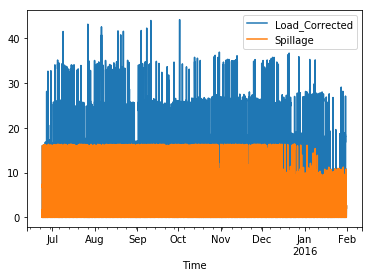

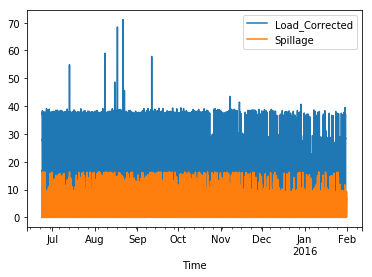

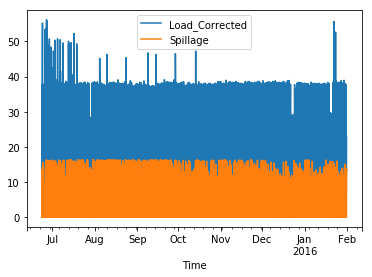

In [10]:
plt.figure(figsize=(16,8))
# ax1 = plt.subplot(121)
# ax2 = plt.subplot(122)
house_time.loc[:,['Load_Corrected', 'Spillage']].plot(kind='line')
house2_time.loc[:,['Load_Corrected', 'Spillage']].plot(kind='line')
house3_time.loc[:,['Load_Corrected', 'Spillage']].plot(kind='line')
#house2_time.loc[:,['Battery_Current','Battery_V']].plot(ax=ax2, kind='line')
plt.show()

In [12]:
house.to_csv('House_2_Processed_TimeSeries.csv')
house2.to_csv('House_3_Processed_TimeSeries.csv')
house3.to_csv('House_4_Processed_TimeSeries.csv')